In [34]:
# Import statements
import tensorflow as tf
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import csv

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [2]:
# Plot formatting defaults
plt.rc('ytick', direction='out')
plt.rc('grid', color='w', linestyle='solid')
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams.update({'font.size': 22})
plt.rc('xtick', direction='out')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [4]:
# Load in train and test data

mat = scipy.io.loadmat('W8_samples.mat')
W8_cell_data = mat['cell_data']

mat = scipy.io.loadmat('W9_samples.mat')
W9_cell_data = mat['cell_data']

del mat

# X_train, y_train = shuffle(W8_cell_data[:,1:], W8_cell_data[:,0])
X_train, X_valid, y_train, y_valid = train_test_split(W8_cell_data[:,1:], W8_cell_data[:,0], test_size=0.1, shuffle= True)

# X_train = W8_cell_data[:,1:]
# y_train = W8_cell_data[:,0]

# X_test, X_valid, y_test, y_valid = train_test_split(W9_cell_data[:,1:], W9_cell_data[:,0], test_size=0.1, shuffle= True)


X_test = W9_cell_data[:,1:]
y_test = W9_cell_data[:,0]

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_train = np.transpose(np.reshape(X_train, (X_train.shape[0], 2, int(X_train.shape[1]/2))), (0, 2, 1))
X_valid = np.transpose(np.reshape(X_valid, (X_valid.shape[0], 2, int(X_valid.shape[1]/2))), (0, 2, 1))
X_test = np.transpose(np.reshape(X_test, (X_test.shape[0], 2, int(X_test.shape[1]/2))), (0, 2, 1))

# Downsample test by 1/100 for testing
y_test = y_test[0::10]*100
X_test = X_test[0::10, :, :]
y_train = y_train[0::50]*100
X_train = X_train[0::50, :, :]
y_valid = y_valid[0::50]*100
X_valid = X_valid[0::50, :, :]

# Save dimensions for LSTM

n_samp, n_time, n_feat = X_train.shape

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(1457, 1200, 2)
(1457,)
(162, 1200, 2)
(162,)
(7109, 1200, 2)
(7109,)


In [30]:
# Load in capacity data for each cell
df = pd.read_csv('cell_caps_interp1.csv', header=None)

In [31]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility

In [54]:
W5_caps = df.iloc[0].to_numpy()
W5_caps = np.reshape(W5_caps, (-1,1))

scaler = MinMaxScaler(feature_range=(0, 1))
W5_caps = scaler.fit_transform(W5_caps)

# split into train and test sets
train_size = int(len(W5_caps) * 0.3)
test_size = len(W5_caps) - train_size
train, test = W5_caps[0:train_size,:], W5_caps[train_size:len(W5_caps),:]
print(len(train), len(test))

88 207


In [55]:
train.shape

(88, 1)

In [60]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [61]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = keras.Sequential()
model.add(layers.LSTM(4, input_shape=(1, look_back)))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


Epoch 1/100


2022-05-24 22:09:48.098879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-24 22:09:48.175804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-24 22:09:48.243883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


86/86 - 1s - loss: 0.5720 - 1s/epoch - 14ms/step
Epoch 2/100
86/86 - 0s - loss: 0.2878 - 354ms/epoch - 4ms/step
Epoch 3/100
86/86 - 0s - loss: 0.1101 - 342ms/epoch - 4ms/step
Epoch 4/100
86/86 - 0s - loss: 0.0294 - 340ms/epoch - 4ms/step
Epoch 5/100
86/86 - 0s - loss: 0.0067 - 329ms/epoch - 4ms/step
Epoch 6/100
86/86 - 0s - loss: 0.0027 - 347ms/epoch - 4ms/step
Epoch 7/100
86/86 - 0s - loss: 0.0023 - 341ms/epoch - 4ms/step
Epoch 8/100
86/86 - 0s - loss: 0.0023 - 332ms/epoch - 4ms/step
Epoch 9/100
86/86 - 0s - loss: 0.0022 - 335ms/epoch - 4ms/step
Epoch 10/100
86/86 - 0s - loss: 0.0022 - 330ms/epoch - 4ms/step
Epoch 11/100
86/86 - 0s - loss: 0.0022 - 328ms/epoch - 4ms/step
Epoch 12/100
86/86 - 0s - loss: 0.0022 - 325ms/epoch - 4ms/step
Epoch 13/100
86/86 - 0s - loss: 0.0022 - 325ms/epoch - 4ms/step
Epoch 14/100
86/86 - 0s - loss: 0.0022 - 331ms/epoch - 4ms/step
Epoch 15/100
86/86 - 0s - loss: 0.0021 - 328ms/epoch - 4ms/step
Epoch 16/100
86/86 - 0s - loss: 0.0021 - 327ms/epoch - 4ms/step

In [70]:
testPredict = np.zeros((testX.shape[0],1))

test_init = model.predict(testX[0,:,:])
testPredict[0,1] = test_init

for i in range(1,testX.shape[0]):
    test_i = model.predict(np.reshape(test_init, (-1, 1, 1)))
    testPredict[i,1] = test_i
    test_init = test_i
    


InvalidArgumentError: Graph execution error:

transpose expects a vector of size 2. But input(1) is a vector of size 3
	 [[{{node transpose}}]]
	 [[sequential_5/lstm_8/PartitionedCall]] [Op:__inference_predict_function_137977]

1/7 [===>..........................] - ETA: 0s

2022-05-24 22:10:27.381672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-24 22:10:27.413522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 31ms/step
Train Score: 0.00 RMSE
Test Score: 0.00 RMSE


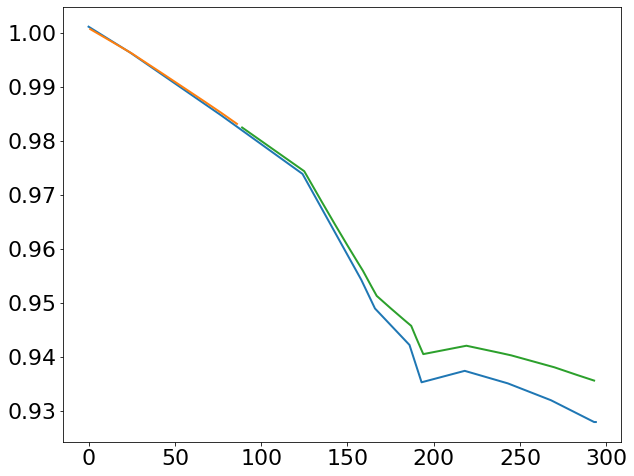

In [62]:
# make predictions
trainPredict = model.predict(trainX)




testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(W5_caps)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(W5_caps)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(W5_caps)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(W5_caps))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
# Plot single training example
plt.plot(X_train[20,:,0])
plt.plot(X_train[20,:,1])
plt.plot(X_valid[20,:,0])
plt.plot(X_valid[20,:,1])
print(X_train.shape)
plt.show()

In [ ]:
# Plot all output values
plt.plot(W8_cell_data[:,0])
plt.plot(W9_cell_data[:,0])
plt.show()

In [5]:
def build_lstm_model():
    model = keras.Sequential()
    model.add(layers.LSTM(10, input_shape=(n_time, n_feat), return_sequences=True))
    model.add(layers.LSTM(10, input_shape=(n_time, n_feat)))
    # model.add(layers.BatchNormalization())
    # Stack LSTM instead of Dense
    # model.add(layers.Dense(20, activation="relu"))  # Add back in if need more than 5 units for LSTM
    # model.add(layers.Dense(40, activation="relu"))  # Add back in if need more than 5 units for LSTM
    # model.add(layers.Dense(20, activation="relu"))  # Add back in if need more than 5 units for LSTM
    # model.add(layers.Dense(5, activation="relu"))   # Add back in if need more than 5 units for LSTM
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="mean_absolute_error",
        metrics=["mean_squared_error"],
    )
    return model

In [9]:
lstm_model = build_lstm_model()
# Check shape of model (need to instantiate input shape)
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1200, 10)          520       
                                                                 
 lstm_5 (LSTM)               (None, 10)                840       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,371
Trainable params: 1,371
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm_model.fit(X_train,y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=10,
                    verbose=2,
                    batch_size=48)

In [ ]:
y_hat = lstm_model.predict(X_test)
y_hat_plot = np.ravel(y_hat)
plt.plot(y_hat_plot)
plt.plot(y_test, linewidth=3)
plt.legend(['Estimated W9', 'Actual W9'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
lstm_model.evaluate(X_test, y_test, verbose=2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.xlabel("Epoch [-]")
plt.ylabel("Loss [-]")
plt.show()

In [ ]:
cnn_model.save("cnnmodel_w8_500_MAE")

In [ ]:
# Validate on W10 cell

mat = scipy.io.loadmat('W10_samples.mat')
W10_cell_data = mat['cell_data']

del mat

X_test_W10 = W10_cell_data[:,1:]
y_test_W10 = W10_cell_data[:,0]*100

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_test_W10 = np.transpose(np.reshape(X_test_W10, (X_test_W10.shape[0], 2, int(X_test_W10.shape[1]/2))), (0, 2, 1))

# Downsample test by 1/10th
y_test_W10 = y_test_W10[0::10]
X_test_W10 = X_test_W10[0::10, :, :]

y_hat_W10 = cnn_model.predict(X_test_W10)
y_hat_plot_W10 = np.ravel(y_hat_W10)
plt.plot(y_hat_plot_W10)
plt.plot(y_test_W10, linewidth=3)
plt.legend(['Estimated W10', 'Actual W10'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
cnn_model.evaluate(X_test_W10, y_test_W10, verbose=2)


Validate on W5 cell

In [ ]:
# Validate on W5 cell

mat = scipy.io.loadmat('W5_samples.mat')
W5_cell_data = mat['cell_data']

del mat

X_test_W5 = W5_cell_data[:,1:]
y_test_W5 = W5_cell_data[:,0]*100

# Reshape for CNN: shape = (# samples, # timesteps, # features)
X_test_W5 = np.transpose(np.reshape(X_test_W5, (X_test_W5.shape[0], 2, int(X_test_W5.shape[1]/2))), (0, 2, 1))

# Downsample test by 1/10th
y_test_W5 = y_test_W5[0::10]
X_test_W5 = X_test_W5[0::10, :, :]

y_hat_W5 = cnn_model.predict(X_test_W5)

y_hat_plot_W5 = np.ravel(y_hat_W5)
plt.plot(y_hat_plot_W5)
plt.plot(y_test_W5, linewidth=3)
plt.legend(['Estimated W5', 'Actual W5'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()
cnn_model.evaluate(X_test_W5, y_test_W5, verbose=2)

In [ ]:
y_hat_plot_W5 = np.ravel(y_hat_W5)
y_hat_plot_w5_test = y_hat_plot_W5.copy()
y_hat_plot_w5_test[y_hat_plot_w5_test>105] = 105
plt.plot(y_hat_plot_w5_test)
plt.plot(y_test_W5, linewidth=3)
plt.legend(['Estimated W5', 'Actual W5'])
plt.xlabel("Datapoint [-]")
plt.ylabel("Capacity [%]")
plt.show()